# VOO Market Regime Prediction Visualization

## Import Libraries and Setup

In [29]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import json
import os
import requests
from dotenv import load_dotenv
from model import MarketRegimeTransformer

# Load environment variables
load_dotenv()

# Configuration
LOOKBACK_WINDOW = 256
N_FEATURES = 7
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRE_LOOKBACK = 20  # For technical indicators

# Model parameters (from training)
D_MODEL = 256
N_HEAD = 8
NUM_FEATURE_LAYERS = 4
NUM_AGGREGATE_LAYERS = 3
DIM_FEEDFORWARD = 1024
DROPOUT = 0.1
NUM_CLASSES = 3

# Alpha Vantage API settings
API_KEY = os.getenv('ALPHA_KEY')
BASE_URL = 'https://www.alphavantage.co/query'

print(f"Using device: {DEVICE}")

Using device: cuda


## Fetch VOO Data from Alpha Vantage

In [30]:
def apply_split_adjustments(df):
    """
    Apply split adjustments to historical OHLCV data.
    
    Standard method: Work backwards through time, accumulating split factors.
    Alpha Vantage already applies the split on the split date itself,
    so we only adjust prices BEFORE the split date.
    """
    # Sort by date ascending
    df = df.sort_index()
    
    # Calculate cumulative split adjustment factor
    # Work backwards through time
    cumulative_factor = 1.0
    factors = []
    
    for i in range(len(df) - 1, -1, -1):
        # First append the current factor
        factors.append(cumulative_factor)
        
        # Then check if this date has a split
        split_coef = df.iloc[i]['split_coefficient']
        if split_coef != 1.0:
            # Update factor for all previous dates (but not this date)
            cumulative_factor *= (1.0 / split_coef)
    
    # Reverse to match original order
    factors = factors[::-1]
    df['split_factor'] = factors
    
    # Apply adjustments to OHLC prices
    # Replace original prices with split-adjusted prices
    for col in ['open', 'high', 'low', 'close']:
        df[col] = df[col] * df['split_factor']
    
    # Volume is adjusted in the opposite direction
    df['volume'] = df['volume'] / df['split_factor']
    
    # Drop the split_factor column as it's no longer needed
    df = df.drop('split_factor', axis=1)
    
    return df

def fetch_voo_data_alpha(symbol='VOO', start_date='2022-01-01', end_date='2025-08-10'):
    """Fetch VOO data from Alpha Vantage API"""
    print(f"Fetching {symbol} data from Alpha Vantage...")
    
    params = {
        'function': 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol': symbol,
        'apikey': API_KEY,
        'outputsize': 'full',
        'datatype': 'json'
    }
    
    try:
        response = requests.get(BASE_URL, params=params, timeout=30)
        data = response.json()
        
        if 'Error Message' in data:
            print(f"Error fetching {symbol}: {data['Error Message']}")
            return None
        elif 'Note' in data:
            print(f"API call limit reached: {data['Note']}")
            return None
        elif 'Time Series (Daily)' not in data:
            print(f"No data found for {symbol}")
            return None
        
        time_series = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(time_series, orient='index')
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        # Rename columns to match Alpha Vantage output
        df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 
                      'volume', 'dividend_amount', 'split_coefficient']
        
        # Convert to numeric
        for col in df.columns:
            df[col] = pd.to_numeric(df[col])
        
        # Apply split adjustments (only for splits, not dividends)
        df = apply_split_adjustments(df)
        
        # Filter to our date range  
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        print(f"Fetched {len(df)} days of data")
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        
        return df
        
    except Exception as e:
        print(f"Exception fetching {symbol}: {str(e)}")
        return None

# Fetch the data with buffer for indicators
df_full = fetch_voo_data_alpha('VOO', '2022-01-01', '2025-08-10')

if df_full is None:
    print("Failed to fetch data. Please check your API key and connection.")
else:
    print(f"\nData shape: {df_full.shape}")
    print(f"\nFirst few rows:")
    print(df_full.head())

Fetching VOO data from Alpha Vantage...
Fetched 903 days of data
Date range: 2022-01-03 to 2025-08-08

Data shape: (903, 8)

First few rows:
              open    high      low   close  adjusted_close     volume  \
2022-01-03  437.93  439.27  435.640  439.25      416.981128  6017303.0   
2022-01-04  440.58  441.26  437.220  439.07      416.810253  6262237.0   
2022-01-05  438.78  439.41  430.525  430.66      408.826619  7539607.0   
2022-01-06  430.20  432.83  427.900  430.08      408.276024  7971547.0   
2022-01-07  430.21  431.36  427.200  428.59      406.861563  6157536.0   

            dividend_amount  split_coefficient  
2022-01-03              0.0                1.0  
2022-01-04              0.0                1.0  
2022-01-05              0.0                1.0  
2022-01-06              0.0                1.0  
2022-01-07              0.0                1.0  


## Define Preprocessing Functions (matching training pipeline)

In [31]:
def calculate_rsi(prices, period=14):
    """Calculate RSI for a price series"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, period=20, num_std=2):
    """Calculate Bollinger Bands width and distance"""
    middle_band = prices.rolling(window=period).mean()
    std_dev = prices.rolling(window=period).std()
    upper_band = middle_band + (num_std * std_dev)
    lower_band = middle_band - (num_std * std_dev)
    
    # BB width (normalized volatility)
    bb_width = (upper_band - lower_band) / middle_band
    
    # BB distance (where price is relative to bands)
    bb_distance = (prices - middle_band) / (upper_band - lower_band)
    
    return bb_width, bb_distance

def preprocess_data_for_prediction(df, start_idx, lookback_window=256, pre_lookback=20):
    """
    Preprocess data exactly as in generate_training_data_v4.py
    """
    # Need pre_lookback + lookback_window data points
    if start_idx < pre_lookback:
        return None
        
    # Get extended data including pre_lookback period for indicators
    extended_data = df.iloc[start_idx-pre_lookback:start_idx+lookback_window]
    
    # Get lookback window
    lookback_data = df.iloc[start_idx:start_idx+lookback_window]
    
    # Calculate technical indicators on extended data
    rsi_full = calculate_rsi(extended_data['close'], period=14)
    bb_width_full, bb_distance_full = calculate_bollinger_bands(extended_data['close'], period=20)
    
    # Extract only the lookback window portion (skip pre_lookback values)
    rsi_window = rsi_full.iloc[pre_lookback:].values
    bb_distance_window = bb_distance_full.iloc[pre_lookback:].values
    
    # Normalize features using only lookback window data
    features = []
    
    # Price features: normalized log returns
    for col in ['open', 'high', 'low', 'close']:
        returns = lookback_data[col].pct_change()
        log_rets = np.log(1 + returns)
        # Drop the first NaN value from pct_change
        log_rets = log_rets.iloc[1:]
        # Use lookback window for normalization
        mean = log_rets.mean()
        std = log_rets.std()
        if std > 0:
            normalized = (log_rets - mean) / std
        else:
            normalized = log_rets - mean
        features.append(normalized.values)
    
    # Volume feature: z-score normalized log volume
    log_volume = np.log(lookback_data['volume'] + 1e-10)  # Add small epsilon to avoid log(0)
    # Drop the first value to match the length of price returns
    log_volume = log_volume.iloc[1:]
    volume_mean = log_volume.mean()
    volume_std = log_volume.std()
    if volume_std > 0:
        volume_normalized = (log_volume - volume_mean) / volume_std
    else:
        volume_normalized = log_volume - volume_mean
    features.append(volume_normalized.values)
    
    # Process RSI (convert from [0,100] to [-1,1])
    rsi_normalized = (rsi_window[1:] - 50) / 50  # Skip first NaN to match other features
    features.append(rsi_normalized)
    
    # Process BB distance (already normalized, just need to match length)
    bb_distance_normalized = bb_distance_window[1:]  # Skip first to match other features
    # Additional normalization based on lookback window stats
    bb_mean = np.nanmean(bb_distance_normalized)
    bb_std = np.nanstd(bb_distance_normalized)
    if bb_std > 0:
        bb_distance_normalized = (bb_distance_normalized - bb_mean) / bb_std
    else:
        bb_distance_normalized = bb_distance_normalized - bb_mean
    features.append(bb_distance_normalized)
    
    # Stack features: shape (lookback_window-1, 7)
    X_sample = np.stack(features, axis=1)
    
    # Skip if we have NaN values
    if np.any(np.isnan(X_sample)):
        return None
    
    return X_sample

def predict_regime(model, data_tensor):
    """Make prediction using the model"""
    with torch.no_grad():
        data_tensor = data_tensor.unsqueeze(0).to(DEVICE)  # Add batch dimension
        class_logits, duration_pred = model(data_tensor)
        
        # Get predicted class
        _, predicted_class = class_logits.max(1)
        predicted_class = predicted_class.item()
        
        # Get class probabilities
        probs = torch.softmax(class_logits, dim=1).cpu().numpy()[0]
        
        # Get duration prediction (in log volume z-score units)
        duration = duration_pred.item()
        
    regime_map = {0: 'bull', 1: 'flat', 2: 'bear'}
    return regime_map[predicted_class], probs, duration

## Load the Trained Model

In [32]:
def load_model():
    """Load the trained model"""
    print("Loading trained model...")
    
    # Initialize model
    model = MarketRegimeTransformer(
        lookback_window=LOOKBACK_WINDOW-1,  # -1 because of pct_change
        n_features=N_FEATURES,
        d_model=D_MODEL,
        nhead=N_HEAD,
        num_feature_layers=NUM_FEATURE_LAYERS,
        num_aggregate_layers=NUM_AGGREGATE_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES
    ).to(DEVICE)
    
    # Load checkpoint
    checkpoint = torch.load('checkpoints/best_model.pth', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Model loaded from epoch {checkpoint['epoch'] + 1}")
    print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")
    
    return model

# Load the model
model = load_model()

Loading trained model...
Model loaded from epoch 13
Validation accuracy: 71.44%


## Visualize Model Prediction vs Actual

In [33]:
def load_clean_30min_data():
    """
    Load the cleaned 30-minute VOO data (standard trading hours only)
    """
    print("Loading cleaned 30-minute data...")
    
    # Check if cleaned file exists
    if not os.path.exists('voo_30min_clean.csv'):
        print("Cleaned data file not found. Please run clean_30min_data.py first.")
        return None
    
    # Load the cleaned CSV
    df_30min = pd.read_csv('voo_30min_clean.csv')
    df_30min['timestamp'] = pd.to_datetime(df_30min['timestamp'])
    df_30min = df_30min.set_index('timestamp')
    
    # Remove the few remaining anomalies (>5% range in 30 minutes)
    df_30min['range_pct'] = ((df_30min['high'] - df_30min['low']) / df_30min['high']) * 100
    anomalies_mask = df_30min['range_pct'] > 5.0
    n_anomalies = anomalies_mask.sum()
    
    if n_anomalies > 0:
        print(f"Removing {n_anomalies} remaining anomalous candles with >5% range")
        df_30min = df_30min[~anomalies_mask]
    
    # Drop the temporary column
    df_30min = df_30min.drop('range_pct', axis=1)
    
    print(f"Loaded {len(df_30min):,} clean 30-minute candles")
    print(f"Date range: {df_30min.index[0]} to {df_30min.index[-1]}")
    
    return df_30min

def calculate_intraday_ema_for_date(df_30min, target_date, ema_window=20):
    """
    Calculate EMA on 30-minute data and get the end-of-day value for a specific date
    """
    # Filter to get all data up to and including the target date
    target_date_str = pd.to_datetime(target_date).strftime('%Y-%m-%d')
    df_up_to_date = df_30min[df_30min.index.date <= pd.to_datetime(target_date_str).date()]
    
    if len(df_up_to_date) == 0:
        return None
    
    # Calculate EMA on all 30-minute data
    ema_30min = df_up_to_date['close'].ewm(span=ema_window, adjust=False).mean()
    
    # Get the last value for the target date (end of trading day)
    target_day_data = ema_30min[ema_30min.index.date == pd.to_datetime(target_date_str).date()]
    
    if len(target_day_data) == 0:
        return None
    
    # Return the last EMA value of that trading day
    return target_day_data.iloc[-1]

# Load the cleaned 30-minute data
df_30min = load_clean_30min_data()

if df_30min is not None:
    print("\nSample of clean 30-minute data:")
    print(df_30min.head())
    
    # Calculate daily EMA values from 30-minute data if we have daily data loaded
    if 'df_full' in globals() and df_full is not None:
        print("\nCalculating daily EMA values from 30-minute data...")
        
        # For each day in our daily data, get the EMA value from 30-minute calculation
        daily_ema_from_30min = []
        for date in df_full.index:
            ema_value = calculate_intraday_ema_for_date(df_30min, date, ema_window=20)
            daily_ema_from_30min.append(ema_value)
        
        # Add to the daily dataframe
        df_full['ema_30min'] = daily_ema_from_30min
        
        # Check how many values we got
        valid_ema = df_full['ema_30min'].notna().sum()
        print(f"Successfully calculated EMA for {valid_ema} out of {len(df_full)} days")
        
        # Show sample
        print("\nSample of daily data with 30-min EMA:")
        print(df_full[['close', 'ema_30min']].tail(10))

Loading cleaned 30-minute data...
Removing 4 remaining anomalous candles with >5% range
Loaded 48,719 clean 30-minute candles
Date range: 2010-09-09 09:30:00 to 2025-08-15 15:30:00

Sample of clean 30-minute data:
                      open   high    low  close  volume
timestamp                                              
2010-09-09 09:30:00  51.25  51.25  50.70  50.87    9500
2010-09-09 10:00:00  50.87  50.87  50.76  50.79    9470
2010-09-09 10:30:00  50.78  50.80  50.74  50.74    5741
2010-09-09 11:00:00  50.84  50.84  50.84  50.84    1000
2010-09-09 11:30:00  50.88  50.88  50.88  50.88     200

Calculating daily EMA values from 30-minute data...
Successfully calculated EMA for 903 out of 903 days

Sample of daily data with 30-min EMA:
             close   ema_30min
2025-07-28  585.44  585.091106
2025-07-29  583.92  584.608022
2025-07-30  583.21  584.106987
2025-07-31  581.02  583.862379
2025-08-01  571.45  574.942097
2025-08-04  580.14  577.974622
2025-08-05  577.35  578.082941
20

## Load 1-Minute Data and Resample to 30-Minute Candles

Creating high-resolution visualization with 30-minute candles...
Predicted regime: FLAT
  Bull: 15.8%
  Flat: 82.5%
  Bear: 1.7%
  Actual days: 4
  Actual volume accumulated: 18061844

Visualization window: 150 days
Showing data from 2024-04-08 09:30:00 to 2024-09-09 15:30:00


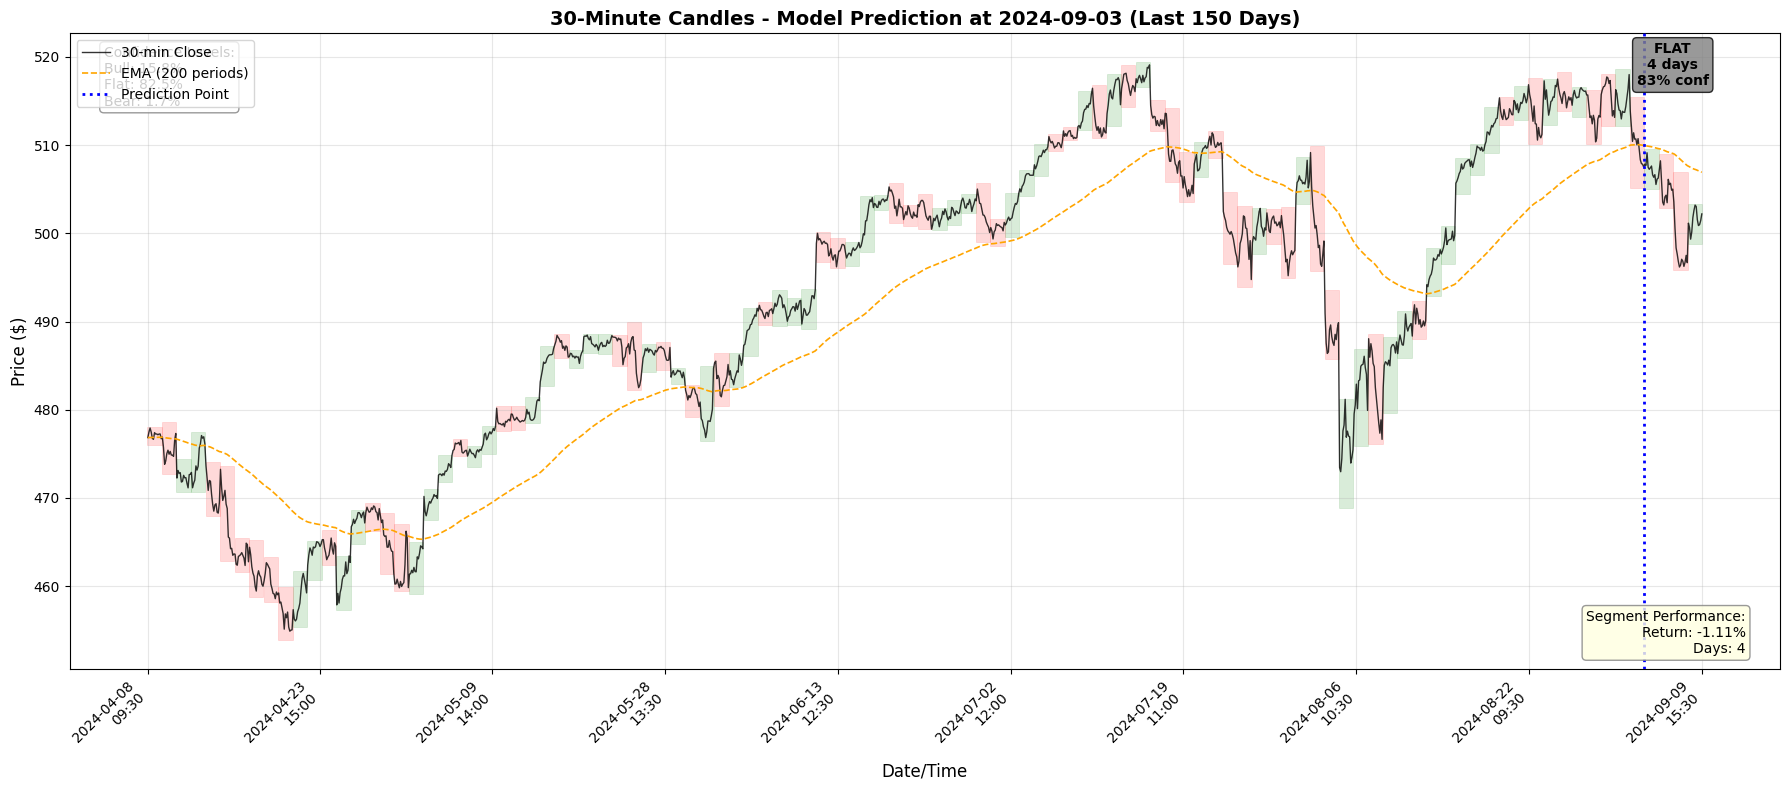

In [ ]:
def visualize_with_30min_candles(df_daily, df_30min_data, model, prediction_point_idx=None, ema_window=20, display_days=150):
    """
    Visualize model prediction using 30-minute candles for more detailed view.
    Uses 30-minute volume data for more precise duration prediction.
    
    prediction_point_idx: Index in the daily dataframe where to make prediction
    display_days: Number of days to display in the visualization (default 150)
    """
    if prediction_point_idx is None:
        prediction_point_idx = len(df_daily) - 100
    
    # Check if we have enough history
    if prediction_point_idx < LOOKBACK_WINDOW + PRE_LOOKBACK:
        print(f"Not enough history at index {prediction_point_idx}")
        return
    
    # Get the prediction date
    prediction_date = df_daily.index[prediction_point_idx]
    
    # Get input data for model (daily data) - using full lookback window
    input_start_idx = prediction_point_idx - LOOKBACK_WINDOW + 1
    
    # Prepare data for prediction using daily data - FULL LOOKBACK FOR CALCULATIONS
    X = preprocess_data_for_prediction(df_daily, input_start_idx, LOOKBACK_WINDOW, PRE_LOOKBACK)
    
    if X is None:
        print("Could not preprocess data for prediction")
        return
    
    # Get model prediction
    X_tensor = torch.from_numpy(X).float()
    regime, probs, duration_zscore = predict_regime(model, X_tensor)
    print(f"Predicted regime: {regime.upper()}")
    print(f"  Bull: {probs[0]:.1%}")
    print(f"  Flat: {probs[1]:.1%}")
    print(f"  Bear: {probs[2]:.1%}")
    
    # CORRECT VOLUME CALCULATION - Matching generate_training_data_v4.py
    # Get lookback window data
    lookback_data = df_daily.iloc[input_start_idx:prediction_point_idx + 1]
    
    # Calculate log volume statistics from the lookback window (lines 238-242 in training)
    log_volumes = np.log(lookback_data['volume'].values)
    # Note: training drops first value after pct_change, but for volume it uses all values
    volume_mean = log_volumes.mean()
    volume_std = log_volumes.std()
    # Convert z-score back to actual volume sum
    # duration_zscore = (log(total_volume) - volume_mean) / volume_std
    # So: log(total_volume) = duration_zscore * volume_std + volume_mean
    log_target_sum = duration_zscore * volume_std + volume_mean
    target_sum_volume = np.exp(log_target_sum)
    
    # Now accumulate DAILY volumes to find segment end
    future_start_idx = prediction_point_idx + 1
    cumulative_volume = 0
    actual_segment_days = 0
    
    # Use daily data for accumulation
    for i in range(future_start_idx, min(len(df_daily), future_start_idx + 100)):
        if i < len(df_daily):
            day_volume = df_daily.iloc[i]['volume']
            cumulative_volume += day_volume
            actual_segment_days += 1
            
            # Check if we've accumulated enough volume
            if cumulative_volume >= target_sum_volume:
                break
    
    # Get the actual end date
    if actual_segment_days > 0:
        segment_end_date = df_daily.index[min(prediction_point_idx + actual_segment_days, len(df_daily) - 1)]
    else:
        segment_end_date = prediction_date + pd.Timedelta(days=30)
    
    print(f"  Actual days: {actual_segment_days}")
    print(f"  Actual volume accumulated: {cumulative_volume:.0f}")
    
    # Convert to 30-minute periods for visualization
    actual_30min_periods = actual_segment_days * 13  # Approximately 13 30-min candles per day
    
    # NOW LIMIT THE VISUALIZATION DATA TO display_days
    # Calculate the start date for visualization (display_days before prediction)
    viz_start_date = prediction_date - pd.Timedelta(days=display_days)
    viz_end_date = segment_end_date + pd.Timedelta(days=1)
    
    mask_viz = (df_30min_data.index >= viz_start_date) & (df_30min_data.index <= viz_end_date)
    df_30min_viz = df_30min_data[mask_viz].copy()
    
    if len(df_30min_viz) == 0:
        print("No 30-minute data available for visualization")
        return
    
    print(f"\nVisualization window: {display_days} days")
    print(f"Showing data from {df_30min_viz.index[0]} to {df_30min_viz.index[-1]}")
    
    # Find the index of prediction point in 30-min data
    pred_point_30min = df_30min_viz[df_30min_viz.index.date <= prediction_date.date()].index[-1]
    pred_point_30min_idx = df_30min_viz.index.get_loc(pred_point_30min)
    
    # Calculate EMA on 30-minute data (for visualization only)
    ema_30min = df_30min_viz['close'].ewm(span=ema_window, adjust=False).mean()
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Define colors
    colors = {'bull': 'green', 'flat': 'gray', 'bear': 'red'}
    
    # First, add daily boxes to indicate trading days
    # These boxes will contain multiple 30-minute candles
    unique_dates = df_30min_viz.index.date
    unique_dates = pd.Series(unique_dates).unique()
    
    for date in unique_dates:
        # Get 30-min data for this day
        day_mask = df_30min_viz.index.date == date
        day_data = df_30min_viz[day_mask]
        
        if len(day_data) > 0:
            # Get all indices for this day (will contain multiple 30-min candles)
            day_indices = [i for i, x in enumerate(df_30min_viz.index.date) if x == date]
            if len(day_indices) > 0:
                start_idx = day_indices[0]  # First 30-min candle of the day
                end_idx = day_indices[-1]   # Last 30-min candle of the day
                
                # Get daily open (from first 30-min candle) and close (from last 30-min candle)
                day_open = day_data.iloc[0]['open']
                day_close = day_data.iloc[-1]['close']
                
                # Determine color based on day performance
                box_color = 'green' if day_close > day_open else 'red'
                
                # Get the daily high and low from all 30-min candles in this day
                day_low = day_data['low'].min()
                day_high = day_data['high'].max()
                
                # Draw rectangle that spans horizontally across all 30-min candles for this day
                # and vertically from day's low to day's high
                from matplotlib.patches import Rectangle
                rect = Rectangle(
                    (start_idx - 0.4, day_low),  # Bottom-left corner (x, y)
                    (end_idx - start_idx + 0.8),  # Width (spans all 30-min candles of the day)
                    (day_high - day_low),          # Height (from low to high)
                    alpha=0.15,                    # Transparency
                    facecolor=box_color,
                    edgecolor=box_color,
                    linewidth=0.5,
                    zorder=1  # Behind the price line
                )
                ax.add_patch(rect)
    
    # Plot 30-minute close prices (these will appear as multiple points within each daily box)
    x_indices = range(len(df_30min_viz))
    ax.plot(x_indices, df_30min_viz['close'], 
            color='black', linewidth=1.0, alpha=0.8, label='30-min Close', zorder=2)
    
    # Plot EMA
    ax.plot(x_indices, ema_30min, 
            color='orange', linewidth=1.2, linestyle='--', 
            label=f'EMA ({ema_window} periods)', zorder=2)
    
    # Draw vertical line at prediction point
    ax.axvline(x=pred_point_30min_idx, color='blue', linestyle=':', linewidth=2, 
               label=f'Prediction Point', zorder=3)
    
    # Calculate position for text annotation
    # Find where the predicted segment ends in the 30-min visualization
    segment_end_30min = df_30min_viz[df_30min_viz.index.date <= segment_end_date.date()]
    if len(segment_end_30min) > 0:
        segment_end_30min_idx = df_30min_viz.index.get_loc(segment_end_30min.index[-1])
    else:
        segment_end_30min_idx = min(pred_point_30min_idx + actual_30min_periods, len(df_30min_viz) - 1)
    
    segment_start_idx = pred_point_30min_idx + 1
    
    if segment_end_30min_idx > segment_start_idx:
        future_data = df_30min_viz.iloc[segment_start_idx:segment_end_30min_idx+1]
        if len(future_data) > 0:
            # Get max price for text positioning
            max_price = future_data['close'].max() * 1.005
            
            # Add text annotation above the predicted segment
            mid_segment = segment_start_idx + (segment_end_30min_idx - segment_start_idx) // 2
            ax.text(mid_segment, max_price * 1.01, 
                    f'{regime.upper()}\n{actual_segment_days} days\n{probs[{"bull": 0, "flat": 1, "bear": 2}[regime]]:.0%} conf',
                    fontsize=10, ha='center', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor=colors[regime], alpha=0.8, edgecolor='black'),
                    zorder=4)
    
    # Add date labels to x-axis
    # Sample dates for x-axis labels
    n_labels = 10
    label_indices = np.linspace(0, len(df_30min_viz)-1, n_labels, dtype=int)
    ax.set_xticks(label_indices)
    ax.set_xticklabels([df_30min_viz.index[i].strftime('%Y-%m-%d\n%H:%M') for i in label_indices], 
                        rotation=45, ha='right')
    
    # Set labels and title
    ax.set_xlabel('Date/Time', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.set_title(f'30-Minute Candles - Model Prediction at {prediction_date.date()} (Last {display_days} Days)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, zorder=0)
    ax.legend(loc='upper left')
    
    # Add confidence text box (top left)
    confidence_text = (f"Confidence Levels:\n"
                      f"Bull: {probs[0]:.1%}\n"
                      f"Flat: {probs[1]:.1%}\n"  
                      f"Bear: {probs[2]:.1%}")
    
    ax.text(0.02, 0.98, confidence_text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'),
            zorder=5)
    
    # Add performance text at the bottom right
    if segment_end_30min_idx > segment_start_idx:
        future_data = df_30min_viz.iloc[segment_start_idx:segment_end_30min_idx+1]
        if len(future_data) > 1:
            # Calculate return from first to last 30-min candle in predicted segment
            actual_return = (future_data['close'].iloc[-1] / future_data['close'].iloc[0] - 1) * 100
            
            perf_text = (f"Segment Performance:\n"
                        f"Return: {actual_return:.2f}%\n"
                        f"Days: {actual_segment_days}")
            
            ax.text(0.98, 0.02, perf_text,
                    transform=ax.transAxes,
                    fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='gray'),
                    zorder=5)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'prediction_date': prediction_date,
        'regime': regime,
        'confidence': probs,
        'actual_30min_periods': actual_30min_periods,
        'actual_days': actual_segment_days,
        'duration_zscore': duration_zscore
    }

# Visualize with 30-minute candles
if df_full is not None and df_30min is not None:
    print("Creating high-resolution visualization with 30-minute candles...")
    # Now using display_days=150 to show only last 150 days
    result_30min = visualize_with_30min_candles(df_full, df_30min, model, 
                                                  prediction_point_idx=6, 
                                                  ema_window=200,
                                                  display_days=150)